In [1]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
import os
import json
import torch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

from collections import Counter
import plotly.graph_objs as go

from preprocessing.cleaning.text_cleaning import process_text_tokens, process_text
from preprocessing.vocabularies.glove_embeddings import prepare_glove_embeddings, load_glove_embeddings


%load_ext autoreload
%autoreload 2

In [3]:
init_train_df = pd.read_csv("../data/raw/quora_question_pairs_train.csv.zip", compression='zip', index_col=0)
init_test_df = pd.read_csv("../data/raw/quora_question_pairs_test.csv.zip", compression='zip', index_col=0)

In [4]:
df_train = init_train_df.copy()
df_test = init_test_df.copy()

## 1.  Побудова словника

In [5]:
def build_vocab(texts, min_freq=2, max_size=50000):
    counter = Counter()

    for text in texts:
        tokens = process_text_tokens(text)
        assert isinstance(tokens, object)
        counter.update(tokens)

    vocab = {"<PAD>": 0, "<UNK>": 1}

    for word, freq in counter.most_common():
        if freq < min_freq:
            continue
        if len(vocab) >= max_size:
            break
        vocab[word] = len(vocab)

    return vocab, counter

In [6]:
def save_vocab(vocab: dict, path: str = "../registry/vocabularies/vocab.json"):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    with open(path, "w", encoding="utf-8") as f:
        json.dump(vocab, f, ensure_ascii=False, indent=2)

In [7]:
all_texts = df_train['question1'].tolist() + df_train['question2'].tolist()
vocab, word_freqs = build_vocab(all_texts, min_freq=2)

In [8]:
save_vocab(vocab)

## 2. Підготуємо тензори

In [9]:
def text_to_sequence(text: str, vocab: dict, max_len: int = 100) -> list:
    tokens = process_text_tokens(text)
    sequence = [vocab.get(token, vocab["<UNK>"]) for token in tokens]
    if len(sequence) < max_len:
        sequence += [vocab["<PAD>"]] * (max_len - len(sequence))
    else:
        sequence = sequence[:max_len]

    return sequence

In [10]:
MAX_LEN = 50

In [30]:
q1_seq_train = [text_to_sequence(q, vocab, max_len=MAX_LEN) for q in df_train["question1"]]
q2_seq_train = [text_to_sequence(q, vocab, max_len=MAX_LEN) for q in df_train["question2"]]
y = torch.tensor(df_train["is_duplicate"].values, dtype=torch.float32)

X_q1_train= torch.tensor(q1_seq_train, dtype=torch.long)
X_q2_train = torch.tensor(q2_seq_train, dtype=torch.long)

In [31]:
prep_data_dir = "../registry/datasets"
os.makedirs(prep_data_dir, exist_ok=True)

torch.save({
    "X_q1": X_q1_train,
    "X_q2": X_q2_train,
    "y": y
}, f"{prep_data_dir}/quora_train_dataset.pt")

In [32]:
q1_seq_test = [text_to_sequence(q, vocab, max_len=MAX_LEN) for q in df_test["question1"]]
q2_seq_test = [text_to_sequence(q, vocab, max_len=MAX_LEN) for q in df_test["question2"]]
y = torch.tensor(df_test["is_duplicate"].values, dtype=torch.float32)

X_q1_test= torch.tensor(q1_seq_test, dtype=torch.long)
X_q2_test = torch.tensor(q2_seq_test, dtype=torch.long)

In [33]:
torch.save({
    "X_q1": X_q1_test,
    "X_q2": X_q2_test,
    "y": y
}, f"{prep_data_dir}/quora_test_dataset.pt")

## 3. Векторизація

In [13]:
embedding_dim = 300

In [14]:
glove_path = prepare_glove_embeddings(dims=embedding_dim,
                                      target_dir="../registry/glove/",
                                      source="url",
                                      local_zip_path="../registry/glove/glove.6B.zip")

The file was found: ../registry/glove/glove.6B.300d.txt


In [15]:
glove_embeddings = load_glove_embeddings(glove_path, embedding_dim)

In [16]:
len(glove_embeddings)

400000

In [17]:
glove_embeddings.get('what')[:10]

array([-2.0017e-01,  1.4302e-01,  5.2055e-02, -8.0884e-04,  1.7009e-02,
        1.4899e-02, -2.5524e-01, -1.7907e-01, -4.6713e-02, -2.0547e+00],
      dtype=float32)

### Подивимось як GloVe репрезентує контекст досліджуваних новин

In [18]:
top_n = 70
title_tokens = []

for title in df_train['question1']:
    tokens = process_text(title)
    title_tokens.extend(tokens)

word_counts = Counter(title_tokens)
most_common_words = [word for word, _ in word_counts.most_common(top_n)]

In [19]:
found_vectors = []
found_words = []

for word in most_common_words:
    if word in glove_embeddings:
        found_vectors.append(glove_embeddings[word])
        found_words.append(word)

In [20]:
vectors = np.stack(found_vectors)
pca = PCA(n_components=2)
reduced = pca.fit_transform(vectors)

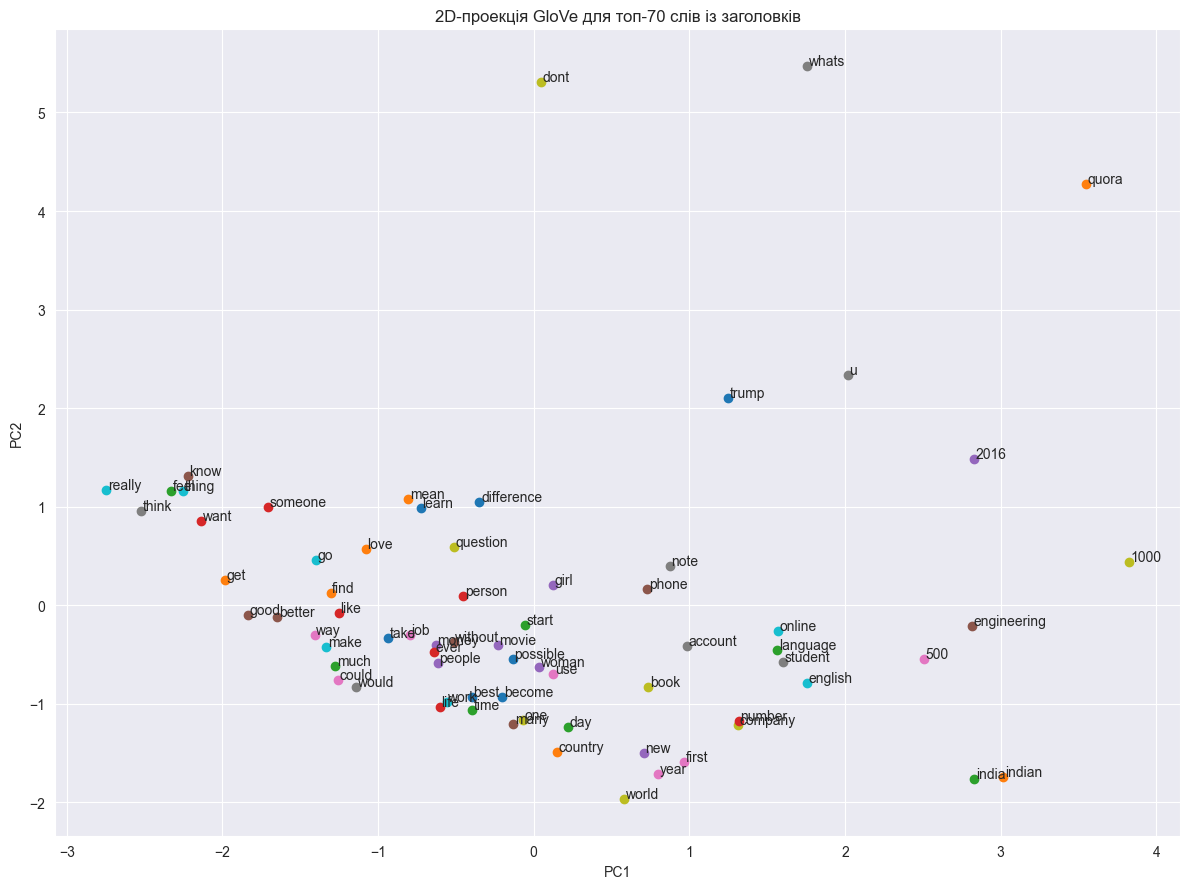

In [21]:
plt.figure(figsize=(12, 9))
for i, word in enumerate(found_words):
    x, y = reduced[i]
    plt.scatter(x, y)
    plt.text(x + 0.01, y + 0.01, word, fontsize=10)

plt.title(f"2D-проекція GloVe для топ-{top_n} слів із заголовків")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.tight_layout()
plt.show()

In [22]:
pca = PCA(n_components=3)
reduced = pca.fit_transform(vectors)

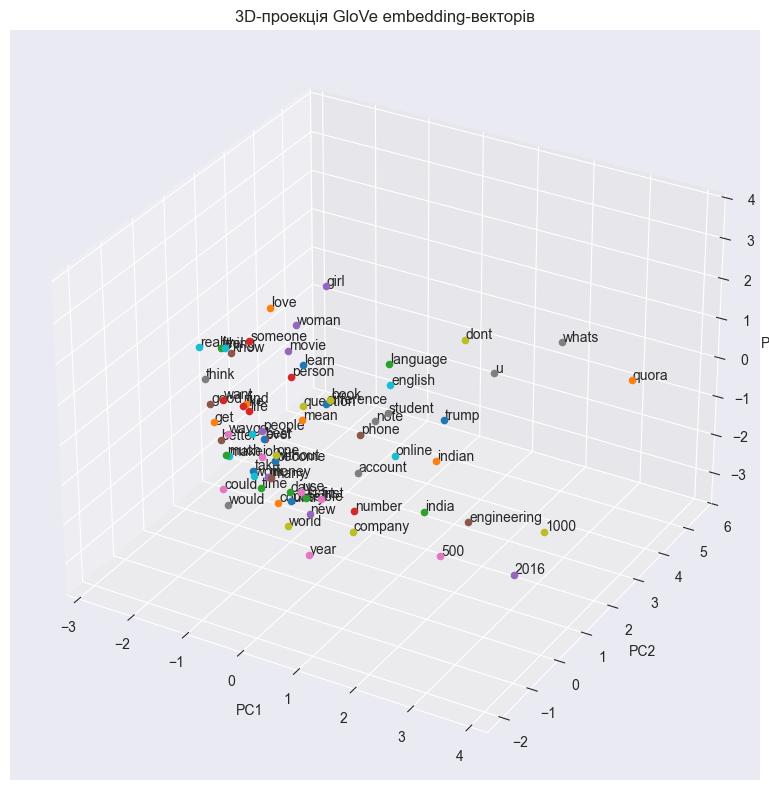

In [23]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

for i, word in enumerate(found_words):
    x, y, z = reduced[i]
    ax.scatter(x, y, z)
    ax.text(x + 0.01, y + 0.01, z + 0.01, word, fontsize=10)

ax.set_title("3D-проекція GloVe embedding-векторів")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.tight_layout()
plt.show()

In [24]:
fig = go.Figure(data=[
    go.Scatter3d(
        x=reduced[:, 0],
        y=reduced[:, 1],
        z=reduced[:, 2],
        mode='markers+text',
        text=found_words,
        textposition="top center",
        marker=dict(size=5, color='blue'),
    )
])

fig.update_layout(
    title="3D-проекція GloVe embedding-векторів",
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    ),
    margin=dict(l=0, r=0, b=0, t=40)
)

fig.show()

In [25]:
def build_embedding_matrix(vocab: dict, glove_embeddings: dict, embedding_dim: int) -> torch.Tensor:
    vocab_size = len(vocab)
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    found = 0
    for word, idx in vocab.items():
        if word in glove_embeddings:
            embedding_matrix[idx] = glove_embeddings[word]
            found += 1
        else:
            embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))

    if "<PAD>" in vocab:
        embedding_matrix[vocab["<PAD>"]] = np.zeros(embedding_dim)

    print(f"Знайдено {found} з {vocab_size} слів у GloVe ({found / vocab_size:.2%})")
    return torch.tensor(embedding_matrix, dtype=torch.float32)


In [26]:
embedding_matrix = build_embedding_matrix(vocab, glove_embeddings, embedding_dim)

Знайдено 39914 з 50000 слів у GloVe (79.83%)


In [27]:
embedding_matrix.shape

torch.Size([50000, 300])

In [28]:
embeddings_dir = "../registry/embeddings"
os.makedirs(embeddings_dir, exist_ok=True)

In [29]:
torch.save(embedding_matrix, f"{embeddings_dir}/embedding_matrix.pt")